In [1]:
import pandas as pd
import numpy as np
import os
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller # ADFuller Hypothesis test
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from pmdarima import auto_arima

In [8]:
ts_data_grouped = pd.read_csv('arimax_modeling_data.csv').set_index('Year')

In [9]:
ts_data_grouped.head()

,state,days_with_aqi,good_days,moderate_days,unhealthy_for_sensitive_groups_days,unhealthy_days,very_unhealthy_days,hazardous_days,max_aqi,90th_percentile_aqi,...,cervix,lung_and_bronchus,stomach,female_breast,prostate,melanomas_of_the_skin,thyroid,ovary,mesothelioma,brain_and_other_nervous_system
Year,,,,,,,,,,,,,,,,,,,,,
2000,California,363.279000,129.055405,131.614307,64.641692,32.701192,5.252650,0.013755,213.935666,129.726187,...,10.0,60.0,9.0,134.6,162.7,18.1,6.9,13.8,1.1,6.2
2001,California,363.108767,122.007743,133.737795,70.297569,30.293275,6.704133,0.068252,227.469711,129.558179,...,9.1,59.1,8.4,133.4,163.8,19.3,7.2,13.6,1.0,6.2
2002,California,362.754063,117.551178,139.338293,62.877890,32.526242,10.341602,0.118859,217.847770,136.188933,...,9.1,57.6,8.5,132.0,166.2,18.9,7.7,13.8,1.0,6.4
2003,California,362.199118,126.832960,134.928487,55.057050,31.569969,13.794660,0.015992,225.947488,141.438401,...,8.3,56.2,8.3,122.0,151.9,18.3,7.9,13.4,1.0,6.5
2004,California,363.168394,118.875883,151.102750,58.618596,31.092621,3.464969,0.013575,190.541881,128.566860,...,8.2,55.5,8.4,120.3,157.8,19.8,8.4,13.1,1.0,6.4


# ARIMAX Modeling Cancer Incidencer Rates vs Air Quality Data

Here we will try an ARIMAX model, a type of regression model that regresses a given time series on its lagged values, as well as on exogenous variables. 

Our intuition here is that human beings generally don't develop cancer immediately after coming into contact with a carcinogen. In our case, we're intuiting that air quality measures might have a lagged effect on cancer incidence, and that these measures themselves may be autocorrelated. 

However, we have a lot of air quality measures and cancer incidence rates to look at.

Let's test an ARIMAX model on those air quality measures that capture days with a high concentration of a given kind of particulate and see if they affect the incidence rate of liver & intrahepatic bile duct cancer. We'll walk through the modeling steps and see what we find. We will then go through a handful of more examples more concisely.

In [10]:
arimax_liver = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10', 
                                'liver_and_intrahepatic_bile_duct']]
arimax_liver.shape
arimax_liver.index = pd.to_datetime(arimax_liver.index, format='%Y')
arimax_liver.index

DatetimeIndex(['2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01'],
              dtype='datetime64[ns]', name='Year', freq=None)

In [11]:
arimax_liver

,days_co,days_no2,days_ozone,days_pm2.5,days_pm10,liver_and_intrahepatic_bile_duct
Year,,,,,,
2000-01-01,3.729155,74.436846,176.911835,104.686231,3.514932,6.7
2001-01-01,1.522703,61.481326,183.976552,112.115517,4.012669,7.3
2002-01-01,1.829375,53.054626,191.024213,112.908444,3.937405,7.3
2003-01-01,1.218672,49.909312,208.105724,100.438645,2.526765,7.4
2004-01-01,0.222068,37.277011,202.737644,120.853557,2.078114,7.8
2005-01-01,0.755770,43.117100,201.729518,114.748454,1.790673,8.6
2006-01-01,0.483553,42.829247,204.813283,109.723257,4.567121,8.6
2007-01-01,0.258408,42.816456,199.041421,115.114365,5.920084,9.0
2008-01-01,0.114490,40.145839,190.682920,127.375387,5.801039,9.0


We only have 20 years and thus only 20 rows in our dataset. This might yield a weak model, but let's soldier on anyway!

## Determining S

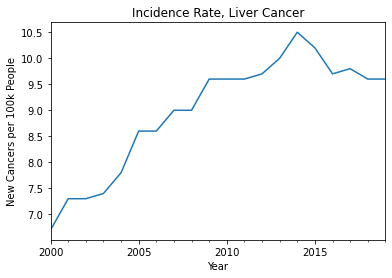

In [12]:
# quick plot of target vs time
arimax_liver['liver_and_intrahepatic_bile_duct'].plot()
plt.ylabel("New Cancers per 100k People")
plt.title("Incidence Rate, Liver Cancer");

## Determine d and D

In [13]:
def interpret_dftest(target_column):
    '''Returns the Test Statistic and p-value for Augmented Dickey-Fuller test on given target column'''
    dftest = adfuller(target_column)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [14]:
# original data (d = 0)
interpret_dftest(arimax_liver['liver_and_intrahepatic_bile_duct'])

Test Statistic    2.297616
p-value           0.998954
dtype: float64

In [15]:
# once differenced data (d = 1)
interpret_dftest(arimax_liver['liver_and_intrahepatic_bile_duct'].diff().dropna())

Test Statistic    0.995046
p-value           0.994213
dtype: float64

In [16]:
# twice differenced data (d = 2)
interpret_dftest(arimax_liver['liver_and_intrahepatic_bile_duct'].diff().diff().dropna())

Test Statistic   -4.828668
p-value           0.000048
dtype: float64

Let's set d=2 and D=2 for now

## Model Preparation

In [17]:
X = arimax_liver.drop(columns=['liver_and_intrahepatic_bile_duct'])
y = arimax_liver['liver_and_intrahepatic_bile_duct']

In [18]:
X.head(2)

,days_co,days_no2,days_ozone,days_pm2.5,days_pm10
Year,,,,,
2000-01-01,3.729155,74.436846,176.911835,104.686231,3.514932
2001-01-01,1.522703,61.481326,183.976552,112.115517,4.012669


## Using auto_arima to determine other components

In [19]:
sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
    d = 2, # we know how much to difference, so don't need to waste time searching for this,
    D = 2, # we know how much to difference, so don't need to waste time searching for this,
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=25.809, Time=0.43 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=23.292, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=23.911, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=23.920, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=21.476, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=22.144, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=18.625, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=16.764, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=18.516, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.960 seconds


This model gave us an AIC=16.764. However, note that we eyeballed our d and D settings. We only have 20 rows of data. Let's remove these parameters and see what auto_arima selects instead if its forced to find optimal d and D values.

In [20]:
sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=25.809, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=23.292, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=23.911, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=23.920, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=21.476, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=22.144, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=18.625, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=16.764, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=18.516, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.535 seconds


In [21]:
# Check orders
print("order: ", sarimax.order)
print("seasonal_order: ", sarimax.seasonal_order)

order:  (0, 2, 1)
seasonal_order:  (0, 0, 0, 0)


In [22]:
y

Year
2000-01-01     6.7
2001-01-01     7.3
2002-01-01     7.3
2003-01-01     7.4
2004-01-01     7.8
2005-01-01     8.6
2006-01-01     8.6
2007-01-01     9.0
2008-01-01     9.0
2009-01-01     9.6
2010-01-01     9.6
2011-01-01     9.6
2012-01-01     9.7
2013-01-01    10.0
2014-01-01    10.5
2015-01-01    10.2
2016-01-01     9.7
2017-01-01     9.8
2018-01-01     9.6
2019-01-01     9.6
Name: liver_and_intrahepatic_bile_duct, dtype: float64

## Modeling

In [28]:
order = (0, 2, 1)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    freq = "AS-JAN", # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [29]:
# check summary for issues
print(fitted_air_sarimax.summary())

                                      SARIMAX Results                                       
Dep. Variable:     liver_and_intrahepatic_bile_duct   No. Observations:                   20
Model:                             SARIMAX(0, 2, 1)   Log Likelihood                  -2.016
Date:                              Fri, 20 Jan 2023   AIC                             18.032
Time:                                      09:51:39   BIC                             23.440
Sample:                                  01-01-2000   HQIC                            18.309
                                       - 01-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -0.4302      0.496     -0.868      0.385      -1.402       0.541
days_no2      -0.24

It seems a handful of these coefficients have z-scores that render them not particularly significant at the 95% level. Let's remove them and see what we get.

In [30]:
sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=25.809, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=23.292, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=23.911, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=23.920, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=21.476, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=22.144, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=18.625, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=16.764, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=18.516, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.526 seconds


In [31]:
order = (0, 2, 1)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [34]:
# check summary for issues
print(fitted_air_sarimax.summary())

                                      SARIMAX Results                                       
Dep. Variable:     liver_and_intrahepatic_bile_duct   No. Observations:                   20
Model:                             SARIMAX(0, 2, 1)   Log Likelihood                  -2.016
Date:                              Fri, 20 Jan 2023   AIC                             18.032
Time:                                      09:52:02   BIC                             23.440
Sample:                                  01-01-2000   HQIC                            18.309
                                       - 01-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -0.4302      0.496     -0.868      0.385      -1.402       0.541
days_no2      -0.24

## Model Predictions

Some considerations this time:
1. Since we did not conduct a train/test split, we'll need to pick an arbitrary date within the dataset to start forecasting from
1. Since we trained on the entire dataset, the `.predict` method can now properly make "in-sample" predictions, since it has the TRUE values (no need to use multi-step out-of-sample forecasting!).

In [35]:
# starting index: about 80% into dataset
starting_index = round(len(y) * .8)
starting_index

16

In [36]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X) 

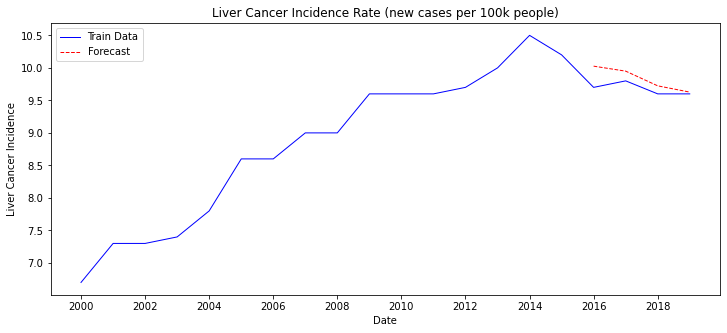

In [38]:
# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Liver Cancer Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(air_test_preds.index, air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Liver Cancer Incidence")

# legend
plt.legend(loc = "upper left");

In [39]:
start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

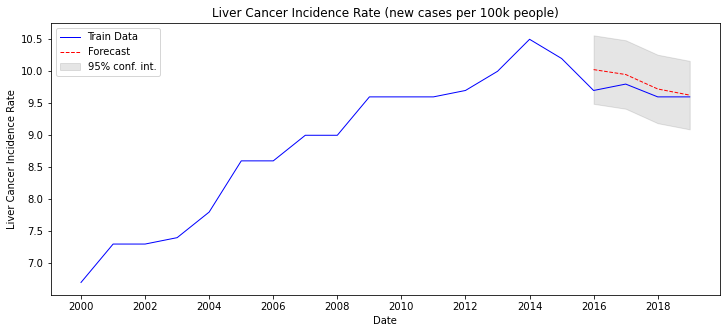

In [40]:
# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Liver Cancer Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Liver Cancer Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

## Model Scoring

In [41]:
# "Test" score
r2_score(y[start_date:], air_test_preds)


# "Test" score
# r2_score(y[start_date:], air_test_preds)

-4.268247646698695

In [42]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [43]:
mape(y[start_date:], air_test_preds)

1.6152334889064583

On one hand, our R2 score was terrible. The apparent coarseness of our model likely stems from the fact we're working from a dataset with 20 rows. However, our Mean Absolute Percentage Error is 1.63%. It seems our model does a decent job of predicting cancer incidence rates!

There are many other cancers in our dataset. Up next, we will present the results of a handful of ARIMAX models for other cancers that yielded statistically significant coefficients and reasonably-accurate predictions as measured by MAPE.

## Oral Cavity and Pharyx Cancer

In [45]:
arimax_ocp = ts_data_grouped[['days_no2','days_ozone', 'days_pm2.5', 
                                'oral_cavity_and_pharynx']]

arimax_ocp.index = pd.to_datetime(arimax_ocp.index, format='%Y')

X = arimax_ocp.drop(columns=['oral_cavity_and_pharynx'])
y = arimax_ocp['oral_cavity_and_pharynx']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=152.302, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5.608, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6.230, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4.693, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6.991, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4.502, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-5.173, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6.553, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-3.033, Time=0.06 sec

Best model:  AR

In [54]:
order = (0, 0, 1)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
#fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [56]:
# check summary for issues
print(fitted_air_sarimax.summary())

                                  SARIMAX Results                                  
Dep. Variable:     oral_cavity_and_pharynx   No. Observations:                   20
Model:                    SARIMAX(0, 0, 1)   Log Likelihood                   8.746
Date:                     Fri, 20 Jan 2023   AIC                             -7.492
Time:                             10:13:14   BIC                             -3.041
Sample:                         01-01-2000   HQIC                            -6.879
                              - 01-01-2019                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_no2       0.0331      0.006      5.649      0.000       0.022       0.045
days_ozone     0.0266      0.002     12.600      0.000       0.022       0.031
days_pm2.5  

Looks like NO2, Ozone, and PM2.5 levels are directly linked to this particular type of cancer! Let's run some predictions and see what we get.

In [48]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X) 

In [57]:
start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

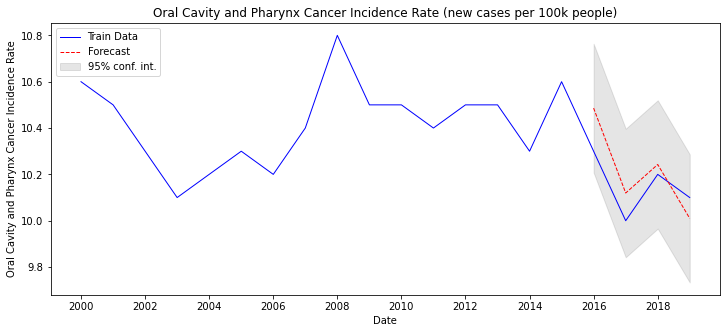

In [58]:
plt.figure(figsize=(12,5))
plt.title("Oral Cavity and Pharynx Cancer Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Oral Cavity and Pharynx Cancer Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

In [51]:
# "Test" score
r2_score(y[start_date:], air_test_preds)

-0.17585694147939246

In [59]:
mape(y[start_date:], air_test_preds)

1.0776778638280484

Our MAPE of 1.07% suggests our model does reasonably well predicting cancer incidence rates!

# Pancreas

In [60]:
arimax_pancreas = ts_data_grouped[['days_co', 'days_no2','days_ozone', 'days_pm2.5', 'days_pm10', 
                                'pancreas']]

arimax_pancreas.index = pd.to_datetime(arimax_pancreas.index, format='%Y')

X = arimax_pancreas.drop(columns=['pancreas'])
y = arimax_pancreas['pancreas']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12.841, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10.010, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12.070, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8.869, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9.179, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=11.957, Time=0.03 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.576 seconds


In [63]:
order = (2,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
#fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               pancreas   No. Observations:                   20
Model:               SARIMAX(2, 1, 0)   Log Likelihood                   0.631
Date:                Fri, 20 Jan 2023   AIC                             14.737
Time:                        10:17:37   BIC                             21.403
Sample:                    01-01-2000   HQIC                            15.400
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co        0.7301      0.502      1.453      0.146      -0.254       1.715
days_no2       0.3507      0.141      2.486      0.013       0.074       0.627
days_ozone     0.3700      0.149      2.491      0.0

It seems NO2, Ozone, PM2.5, and (to a lesser extent) PM10 are directly linked to pancreatic cancer incidence.

In [62]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X) 

In [65]:
start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

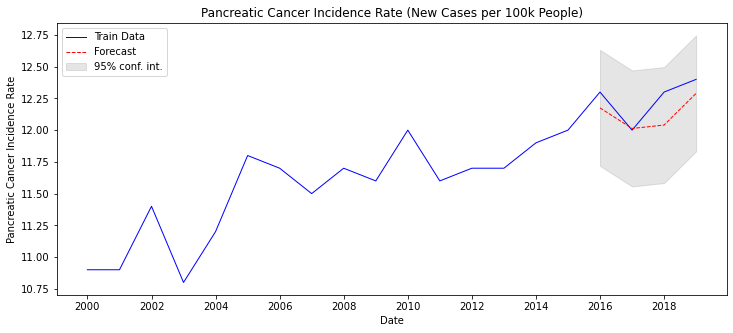

In [67]:
plt.figure(figsize=(12,5))
plt.title("Pancreatic Cancer Incidence Rate (New Cases per 100k People)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Pancreatic Cancer Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

In [68]:
# "Test" score
r2_score(y[start_date:], new_air_test_preds)

-0.06000325935543782

In [70]:
mape(y[start_date:], new_air_test_preds)

1.0311240602616965

We again have a solid MAPE score of ~ 1.03%

# Leukemias

In [71]:
arimax_leukemias = ts_data_grouped[['days_no2','days_ozone', 'days_pm2.5', 
                                'leukemias']]

arimax_leukemias.index = pd.to_datetime(arimax_leukemias.index, format='%Y')

X = arimax_leukemias.drop(columns=['leukemias'])
y = arimax_leukemias['leukemias']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=160.832, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=21.986, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=24.002, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=22.528, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=23.793, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=16.577, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=25.504, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14.971, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=35.198, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=16.257, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=18.917, Time=0.13 sec

Best mo

In [73]:
order = (1,0,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:              leukemias   No. Observations:                   20
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  -2.975
Date:                Fri, 20 Jan 2023   AIC                             15.950
Time:                        10:23:05   BIC                             20.672
Sample:                    01-01-2000   HQIC                            16.749
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_no2       0.0411      0.022      1.833      0.067      -0.003       0.085
days_ozone     0.0339      0.006      6.146      0.000       0.023       0.045
days_pm2.5     0.0349      0.005      7.226      0.0

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


When it comes to leukemias, NO2, Ozone, and PM2.5 tend to drive incidence rates.

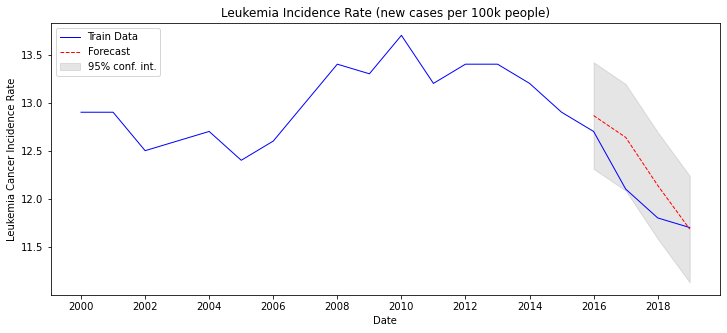

In [74]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X)

start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Leukemia Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Leukemia Cancer Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

In [75]:
# "Test" score
r2_score(y[start_date:], new_air_test_preds)

0.2891875973467165

In [77]:
mape(y[start_date:], new_air_test_preds)

2.1901948348093576

Here our MAPE score is a little bit looser - 2.19%

# Urinary Bladder

In [78]:
arimax_urinary_bladder = ts_data_grouped[['days_co', 
                                'urinary_bladder']]

arimax_urinary_bladder.index = pd.to_datetime(arimax_urinary_bladder.index, format='%Y')

X = arimax_urinary_bladder.drop(columns=['urinary_bladder'])
y = arimax_urinary_bladder['urinary_bladder']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=33.626, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=30.498, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=31.642, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=24.816, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=21.222, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=21.571, Time=0.03 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0] intercept
Total fit time: 0.408 seconds


In [83]:
order = (3,2,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:        urinary_bladder   No. Observations:                   20
Model:               SARIMAX(3, 2, 0)   Log Likelihood                   1.081
Date:                Fri, 20 Jan 2023   AIC                              7.837
Time:                        10:25:09   BIC                             11.378
Sample:                    01-01-2000   HQIC                             7.800
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_co       -0.6578      0.157     -4.190      0.000      -0.966      -0.350
ar.L1         -1.0826      0.382     -2.834      0.005      -1.831      -0.334
ar.L2         -0.9435      0.452     -2.088      0.0

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


An interesting and unintuitive result - judging from the output, it looks like CO reduces urinary bladder cancer incidence. It's also the case that this incidence rate is correlated with its lagged values. This result might be better evaluated with more data. For the same reason the results we've seen so far should be taken with a grain of salt. We're only working with 20 observations! Now let's see how well our model predicts incidence rates.

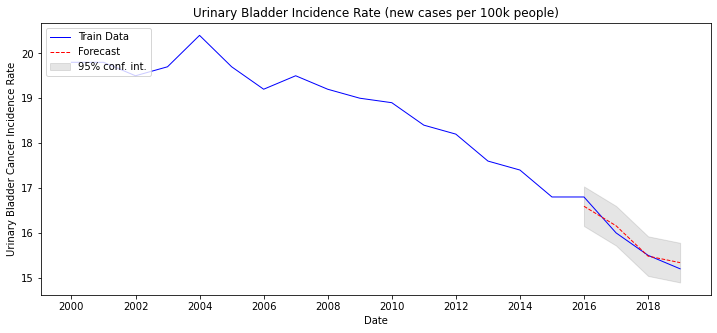

In [84]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X)

start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Urinary Bladder Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Urinary Bladder Cancer Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

In [86]:
# "Test" score
r2_score(y[start_date:], new_air_test_preds)

0.9406443675690838

In [88]:
mape(y[start_date:], new_air_test_preds)

0.8105918100334345

Despite the odd ARIMAX output, this model does an incredible job at predicting incidence rates (MAPE of 0.81% and even an R2 score of 94%).

# Cervix

In [89]:
arimax_cervix = ts_data_grouped[['days_no2', 
                                'cervix']]

arimax_cervix.index = pd.to_datetime(arimax_cervix.index, format='%Y')

X = arimax_cervix.drop(columns=['cervix'])
y = arimax_cervix['cervix']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22.641, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.646, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22.161, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23.283, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23.607, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23.609, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25.607, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=24.010, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.283 seconds


In [95]:
order = (1,1,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:                 cervix   No. Observations:                   20
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  -1.822
Date:                Fri, 20 Jan 2023   AIC                              9.645
Time:                        10:52:42   BIC                             12.316
Sample:                    01-01-2000   HQIC                            10.013
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_no2       0.0372      0.014      2.581      0.010       0.009       0.066
ar.L1         -0.5559      0.228     -2.438      0.015      -1.003      -0.109
sigma2         0.0717      0.034      2.094      0.0

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In this case, we find that NO2 influences cervical cancer rates.

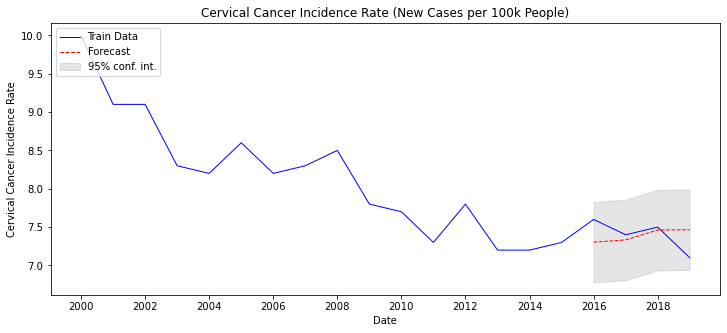

In [92]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X)

start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Cervical Cancer Incidence Rate (New Cases per 100k People)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Cervical Cancer Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

In [93]:
# "Test" score
r2_score(y[start_date:], new_air_test_preds)

-0.6267805424702912

In [96]:
mape(y[start_date:], new_air_test_preds)

2.618123079138809

Our model does a reasonably good job of predicting cervical cancer incidence rates. MAPE score of 2.6%.

## Female Breast Cancer

In [97]:
arimax_female_breast = ts_data_grouped[['days_no2','days_ozone', 'days_pm2.5', 'days_pm10',
                                'female_breast']]

arimax_female_breast.index = pd.to_datetime(arimax_female_breast.index, format='%Y')

X = arimax_female_breast.drop(columns=['female_breast'])
y = arimax_female_breast['female_breast']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=251.702, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=116.132, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=117.769, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=118.124, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=119.569, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=109.525, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=111.743, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=107.533, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=117.085, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=109.517, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=114.612, Time=0.10 se

In [103]:
order = (1,0,0)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:          female_breast   No. Observations:                   20
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -41.178
Date:                Fri, 20 Jan 2023   AIC                             94.355
Time:                        10:59:03   BIC                            100.022
Sample:                    01-01-2000   HQIC                            95.314
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_no2       0.5928      0.060      9.836      0.000       0.475       0.711
days_ozone     0.2695      0.023     11.804      0.000       0.225       0.314
days_pm2.5     0.3506      0.025     14.057      0.0

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Seems like breast cancer incidence rates are influenced by NO2, Ozone, PM2.5 and PM10.

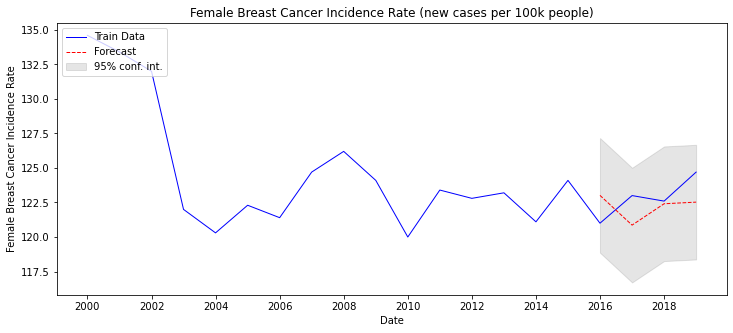

In [104]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X)

start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Female Breast Cancer Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Female Breast Cancer Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

In [105]:
# "Test" score
r2_score(y[start_date:], new_air_test_preds)

-0.9333390513305051

In [106]:
mape(y[start_date:], new_air_test_preds)

1.3257526642193975

Our model does a decent job of predicting female breast cancer rates, with a MAPE of 1.3%

## Mesothelioma

In [111]:
arimax_mesothelioma = ts_data_grouped[['days_no2','days_ozone', 'days_pm2.5', 'days_pm10',
                                'mesothelioma']]

arimax_mesothelioma.index = pd.to_datetime(arimax_mesothelioma.index, format='%Y')

X = arimax_mesothelioma.drop(columns=['mesothelioma'])
y = arimax_mesothelioma['mesothelioma']

sarimax = auto_arima(
    y, # data
    exogenous = X, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
#    d = 0, 
#    D = 0, 
    seasonal = False,
    m = 1,
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33.871, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-35.961, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-38.505, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.844, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-36.712, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-34.692, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-36.142, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.381 seconds


In [112]:
order = (0,1,1)
seasonal_order = (0, 0, 0, 0)

# instantiate
air_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

#fit
fitted_air_sarimax = air_sarimax.fit() # stats model returns fitted model

# fit, in case of convergence warning
#fitted_air_sarimax = air_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

# check summary for issues
print(fitted_air_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:           mesothelioma   No. Observations:                   20
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  19.973
Date:                Fri, 20 Jan 2023   AIC                            -27.947
Time:                        11:01:35   BIC                            -22.948
Sample:                    01-01-2000   HQIC                           -27.450
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_no2      -0.0502      0.024     -2.079      0.038      -0.098      -0.003
days_ozone    -0.0472      0.022     -2.107      0.035      -0.091      -0.003
days_pm2.5    -0.0469      0.023     -2.065      0.0

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


Seems that mesothelioma incidence rates are influenced by NO2, Ozone, PM2.5 and PM10

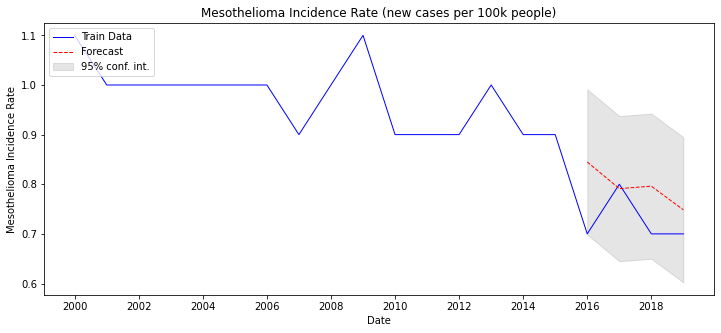

In [113]:
# Test predictions (that are actually in-sample!)
air_test_preds = fitted_air_sarimax.predict(start = 16, dynamic = False, exog=X)

start_date = 16
end_date = 19

prediction_obj = fitted_air_sarimax.get_prediction(start_date, end_date, exog=X, dynamic = False)

# Test predictions (that are actually in-sample!)
new_air_test_preds = prediction_obj.predicted_mean

# Test prediction confidence intervals
air_conf_ints = prediction_obj.conf_int()
air_lower_ints = air_conf_ints.iloc[:,0]
air_upper_ints = air_conf_ints.iloc[:,1]

# Old visualization function doesn't work properly without train/test split
plt.figure(figsize=(12,5))
plt.title("Mesothelioma Incidence Rate (new cases per 100k people)")

# train data
plt.plot(y.index, y, lw=1, color='blue', ls='solid', label='Train Data')

# test predictions
plt.plot(new_air_test_preds.index, new_air_test_preds, lw=1, color='red', ls='dashed', label='Forecast')

#  labels
plt.xlabel("Date")
plt.ylabel("Mesothelioma Incidence Rate")

# confidence intervals
plt.fill_between(new_air_test_preds.index, air_lower_ints, air_upper_ints, color='k', alpha=0.1, label ="95% conf. int.");
# legend
plt.legend(loc = "upper left");

In [114]:
# "Test" score
r2_score(y[start_date:], new_air_test_preds)

-3.355274516736695

In [115]:
mape(y[start_date:], new_air_test_preds) # Not particularly good!

10.615201997032347

## Air Quality and Cancer Incidence - ARIMAX Modeling Conclusions

For the varieties of cancer presented, it seems that there is a direct and statistically significant relationship between cancer incidence rates and the number of days in which certain pollutants, particularly NO2, Ozone and PM2.5, were present in the air in high concentrations. 

The ARIMAX models we constructed also tended to do a good job in predicting cancer incidence rates in California over time. However, our modeling in this section is hamstrung to the extent that it relies on data consisting of 20 observations. It is not surprising that our R2 scores tended to be dismal, whatever or MAPE scores turned out to be.

In a new iteration of this modeling phase, it would be helpful to get granular, year-by-year, cancer incidence rates by county so that we are not in the position to aggregate at the state level and thus have more data with which to generate more robust models. That being said, our analysis yielded some interesting relationships - who would've thought that breathing in common particulates could give you pancreatic cancer (as opposed to the more usual suspect - lung cancer)?